In [ ]:
# Standard library imports
import os       # OS interface for file/dir access
import pathlib  # Object-oriented filesystem path

# Computer Vision lib
import cv2          # OpenCV for image processing operations

# Numerical Computing lib
import numpy as np  # Array computing lib

# Data Visualization
import pandas as pd             # Data manipulation and analysis
import matplotlib.pyplot as plt # Plotting libraru for visualization
import matplotlib as mpl        # Core matplotlib functionality
import seaborn as sns           # Statistical data visualization based on matplotlib

# TensorFlow Framework
import tensorflow as tf 

import mlflow               # MLFlow
import mlflow.tensorflow    # MLFlow integration for TensorFlow models

# Keras Layer and Models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import image_dataset_from_directory

# Pre-Trained models for transfer learning
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2                                  # Pre-trainer CNN architectures
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input          # ResNet50 preprocessing
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input                # VGG16 preprocessing
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input   # MobileNetV2 preprocessing

# Training callbacks for optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    # EarlyStoppting: Stops training when validation loss stops improving
    # ModelCheckpoint: Saves best model during training
    # ReduceLROnPlateau: Reduce learning rate when validation loss plateaus

# Model evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
    # classification_report: Precision, recall, F1-score for each class
    # confusion_matrix: Matrix showing ture vs predicte classification
    # roc_curve: Reciever Operating Characteristic curve data
    # auc: Area under the curve calculation

# Data preprocessing utilities
from sklearn.preprocessing import label_binarize            # Comvert labels to binary format for multi-class ROC
from sklearn.utils.class_weight import compute_class_weight # Handles class imbalance
from itertools import cycle                                 # Cycle through colors for multi-class ROC plots

In [ ]:
# === CONFIG CONSTANT ===

# Dataset Config
DATASET = './Rice_Leaf_Disease/'            # Root dir containing the dataset
TRAIN_DIR = os.path.join(DATASET, 'train')  # Training data directory path

# Image Preprocessing Param
IMG_SIZE = (224, 224)   # Target image spatial dimenstion (height, width)
BATCH_SIZE = 16         # Number of images processed simultaneously during training

# Training Configuration
VALIDATION_SPLIT = 0.2  # Percentage of training data used for validation
RANDOM_SEED = 42        # Fixed seeds for consistent results across different runs

MLFLOW_EXPERIMENT_NAME = "Rice_Leaf_Disease_Classification" # ML Flow Experiment name

In [ ]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

<Experiment: artifact_location='file:///c:/Users/ricca/OneDrive%20-%20Bina%20Nusantara/Datathon%20UI%202025/Rice%20Leaf%20Diseases/mlruns/894291482847743891', creation_time=1750785259692, experiment_id='894291482847743891', last_update_time=1750785259692, lifecycle_stage='active', name='Rice_Leaf_Disease_Classification', tags={'mlflow.sharedViewState.d537fdc0c959fa49a2e0b67727b54010fcd4ffd194d195a2598ac3fdf5c6e596': '{"searchFilter":"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["attributes.`Source`","attributes.`Models`","attributes.`Dataset`"],"runsExpanded":{},"runsPinned":[],"runsHidden":[],"runsHiddenMode":"FIRST_10_RUNS","viewMaximized":false,"runListHidden":false,"isAccordionReordered":false,"groupBy":"","groupsExpanded":{}}',
 'mlflow.sharedViewState.f1a12524

In [ ]:
# === DATASET LOADING AND PREPARATION ===
"""
Load the dataset from directory folder
Creates lables based on the subdirectory names
"""

full_dataset = image_dataset_from_directory(
    TRAIN_DIR,                  # Source dir containing subdir
    image_size=IMG_SIZE,        # Resize images to the defined spatial dimensions
    batch_size=BATCH_SIZE,      # Group images into pre-defined batches
    label_mode='categorical',   # One-hot encoded lables for multi-class classification
    shuffle=True,               # Randomize order to prevent overfitting to data sequence
    seed=RANDOM_SEED,           # Ensure reproducible shuffling across runs
)

Found 16751 files belonging to 10 classes.


In [ ]:
# Extract class name from dataset (derived from subdir names)
class_names = full_dataset.class_names              # List of disease classes found in dataset

# Display batch dimensions for verification
for images, labels in full_dataset.take(1):         # Take the first batch for verification    
    print(f'Bentuk batch gambar: {images.shape}')   # Image batch shape: (batch_size, height, width, channels)
    print(f'Bentul batch label: {labels.shape}')    # Label batch shape: (batch_size, num_classes)

Bentuk batch gambar: (16, 224, 224, 3)
Bentul batch label: (16, 10)


In [ ]:
# Calculate the total number of images across all classes
total_image_count = sum(len(os.listdir(os.path.join(TRAIN_DIR, class_name))) for class_name in os.listdir(TRAIN_DIR))
print(f'Total image file: {total_image_count}')

Total image file: 16751


In [ ]:
# === DATASET SPLITTING CONFIG ===

# Convert Batched Dataset to Unbatched for Flexible Splitting
full_dataset_unbatched = full_dataset.unbatch()

# Dataset Splitting Configuration (70% train, 10% validaton, 20% testing)
train_size = int(0.7 * total_image_count)               # training
val_size = int(0.1 * total_image_count)                 # validation
test_size = total_image_count- train_size - val_size    # testing

print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

# Calculate steps per epoch for training
steps_per_epoch = train_size // BATCH_SIZE

# Handle remainder images dont fill a complete batch
if train_size % BATCH_SIZE != 0:
    steps_per_epoch += 1    # Adds extra step for partial batch 

print(f'Steps per epoch: {steps_per_epoch}')

Train size: 11725, Validation size: 1675, Test size: 3351
Steps per epoch: 733


In [ ]:
# === DATASET SPLITTING AND SHUFFLING ===

# Re-shuffle the entire unbatched dataset to ensure random distribution
full_dataset_unbatched = full_dataset_unbatched.shuffle(
    buffer_size=total_image_count,  # buffer size equals total images for complete randomization
    seed=RANDOM_SEED)               # Maintaim reproducibility across runs

# Split dataset into train, validtion, and test sets
test_dataset = full_dataset_unbatched.take(test_size)       # First samples used for testing
train_val_dataset = full_dataset_unbatched.skip(test_size)  # Skip test sample, rest used for training
validation_dataset = train_val_dataset.take(val_size)       # val_size samples for validation
train_dataset = train_val_dataset.skip(val_size)            # Remaining samples for training

In [ ]:
# Batch training dataset to calculate class weight
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
# === Extract all labels from training dataset for class weight computation

# This helps handle class imbalance by giving more weight to underrepresented classes
all_labels = np.concatenate([y for x, y in train_dataset], axis=0)  # Combine all label batches
integer_labels = np.argmax(all_labels, axis=1)                      # Convert one-hot integer labels

# Calculate balanced class weights to address class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',            # Automatically balance classes inversely proportional to frequency
    classes=np.unique(integer_labels),  # All unique class indices
    y=integer_labels                    # Training labels for weight calculation
)

# Convert to dictionary format required by Keras
class_weights = dict(zip(np.unique(integer_labels), class_weights))
print("Class weights:", class_weights)

Class weights: {0: 0.9138737334372564, 1: 0.9026173979984603, 2: 0.9261453396524486, 3: 0.7842809364548495, 4: 0.8763079222720478, 5: 1.1643495531281032, 6: 1.747391952309985, 7: 1.1295761078998072, 8: 1.0630099728014506, 9: 0.9571428571428572}


In [ ]:
# Unbatch for augmetation pipeline setup
train_dataset = train_dataset.unbatch()

In [ ]:
# === DATA AUGMENTATION SETUP ===

# Define data augmentation pipeline to increase dataset diversity
# This helps prevent overfitting and improves model generalization
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),# Randomly flip images horizontally
    layers.RandomRotation(0.3),     # Rotate images by up to 30% of full rotation
    layers.RandomZoom(0.3),         # Zoom in/out by up to 30%
    layers.RandomBrightness(0.2),   # Adjust brightness by up to 20%
    layers.RandomContrast(0.2)      # Adjust contract by up to 20% 
], name='data_augmentation')        

# Function to apply augmentation during training
def apply_augmentation(image, label):
    # Applied to training images only
    return data_augmentation(image, training = True), label

In [ ]:
# === TRAINING DATASET OPTIMIZATION ===

# TensorFlow's AUTOTUNE automatically optimizes performance parameter
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training dataset with caching, shuffling, batching, and prefetching
train_dataset = train_dataset.cache().repeat().shuffle(
    buffer_size=1000,   # Smaller buffer for memory efficieny during training
    seed=RANDOM_SEED
).batch(BATCH_SIZE).map(
    apply_augmentation,         # Apply augmentation to each batch
    num_parallel_calls=AUTOTUNE # Parallelize augmentation for speed
).prefetch(buffer_size=AUTOTUNE)# Prefetch next batch while training current batch

# Optimize validation dataset (no augmentation needed)
validation_dataset = validation_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Optimize test dataset (no augmentation needed)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# === MODEL CREATION FUNCTION ===

def create_classifier_model(base_model, num_classes, model_name):
    """
    Create a transfer learning classifier using pre-trained base model
    Argument:
        1. base_model: Pre-trained model
        2. num_classes: Number of disease classes to classify
        3. model_name: Name for the model (used in loggign and saving)
    Returns:
        Compiled keras modela ready for training
    """
    # Freeze base model
    base_model.trainable = False            

    # classification
    inputs = base_model.input                           
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)  # Add global average pooling
    x = layers.Dense(512)(x)                # Add dense layer of 512 neurons
    x = layers.BatchNormalization()(x)      # Add batch normalization
    x = layers.Activation("relu")(x)        # Add activation
    x = layers.Dropout(0.5)(x)              # Add dropout
    outputs = layers.Dense(num_classes, activation='softmax')(x)    # Classification layer
    
    # Create and compile model
    model = Model(inputs = inputs, outputs = outputs, name=model_name)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lowered learning rate
                  loss='categorical_crossentropy',  # Multiclass classification loss
                  metrics=['accuracy'])             # Tracks accuracy during learning
    return model

In [ ]:
# === TRAINING VISUALIZATION FUNC ===

def plot_history(history, model_name):
    """
    Plot training history (accuracy and loss) for model evaluation
    Args:
        1. history: keras training history object
        2. model_name: Name of the model for plot titles and file naming
    Returns:
        String path to saved plot file
    """
    # Convert history to DataFrame for easier manipulation
    history_df = pd.DataFrame(history.history)
    
    # Plot
    plt.figure(figsize=(12, 6)) # Create subplot layout for accuracy and loss
    # Plot accuracy trends
    plt.subplot(1, 2, 1)        
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss trends
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Adjust layout and save plot
    plt.tight_layout()
    
    # Save plot to models directory
    plot_path = f"models/{model_name}_training_history.png"
    plt.savefig(plot_path)
    plt.show()

    return plot_path

In [ ]:
# === TRAINING AND EXPERIMENT LOGGING ===

def train_and_log_experiment(model_name, base_model_class, preprocess_function, train_dataset, validation_dataset, img_size, num_classes, class_weight, epochs = 25):
    """
    Train a model with MLflow experiment tracking and logging.

    Args:
        1. model_name: Name of the model architecture (e.g., 'ResNet50')
        2. base_model_class: Pre-trained model class (ResNet50, VGG16, etc.)
        3. preprocess_function: Model-specific preprocessing function
        4. train_dataset: Training dataset
        5. validation_dataset: Validation dataset
        6. img_size: Input image dimensions tuple
        7. num_classes: Number of disease classes
        8. class_weight: Dictionary of class weights for imbalanced data
        9. epochs: Number of training epochs (default: 25)
    Returns:
        Training history object containing metrcis for each epoch
    """
    # Start MLflow run for experiment tracking
    with mlflow.start_run():
        # Log hyperparameters for reproducibility
        mlflow.log_params({
            'model_name': model_name,
            'img_size': img_size[0],    # Log image size 
            'num_classes': num_classes,
            'epochs': epochs,
            'optimizer': 'Adam'
        })
        
        # Create models directory if it doesn't exist
        os.makedirs('models', exist_ok=True)
        
        # Preprocessing for specific model
        def preprocess_for_model(image, label):
            return preprocess_function(image), label
        
        # Apply preprocessing
        train_dataset = train_dataset.map(preprocess_for_model, num_parallel_calls= AUTOTUNE)
        validation_dataset = validation_dataset.map(preprocess_for_model, num_parallel_calls= AUTOTUNE)
        
        # Initialize base model
        base_model = base_model_class(input_shape = img_size + (3,), include_top=False, weights='imagenet')
        # Create custom classifier
        model = create_classifier_model(base_model, num_classes, model_name)
        
        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience = 5, verbose = 1,restore_best_weights=True)
        
        # Model checkpoint to save the best model
        checkpoint_path = f'models/best_model_{model_name}.keras'
        model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
        
        # Reduce learning rate when validation loss plateaus
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=3, 
            min_lr=1e-6, 
            verbose=1)
        
        # Callbacks are combined
        callbacks_list = [early_stopping, model_checkpoint, reduce_lr]
        
        # Train the model with the config
        history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch, 
            callbacks=callbacks_list,
            class_weight=class_weight
        )
        
        # Metric logging to MLFLOW
        final_val_loss = history.history['val_loss'][-1]
        final_val_accuracy = history.history['val_accuracy'][-1]
        final_train_accuracy = history.history['accuracy'][-1]
        best_val_loss = min(history.history['val_loss'])
        best_val_accuracy = max(history.history['val_accuracy'])
        mlflow.log_metrics({
            'final_val_loss': final_val_loss,
            'final_val_accuracy': final_val_accuracy,
            'final_train_accuracy': final_train_accuracy,
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_accuracy
        })
        plot_artifact = plot_history(history, model_name)
        mlflow.log_artifact(plot_artifact, artifact_path=f"{model_name}_training_history")
        mlflow.log_artifact(checkpoint_path, artifact_path=f"best_{model_name}_model")
        mlflow.tensorflow.log_model(model, registered_model_name= model_name, artifact_path=f"{model_name}_model")
    return history

In [ ]:
# === EXPERIMENT CONFIGURATIONS ===

# Define experiments for different pre-trained models
# Each experiment contains model-specific preprocessing and layer information
experiments =[
    {
        'model_name': 'ResNet50',
        'base_model_class': ResNet50,
        'preprocess_function': resnet_preprocess_input,
        'last_conv_layer_name' : 'conv5_block3_out'
    },
    {
        'model_name': 'VGG16',
        'base_model_class': VGG16,
        'preprocess_function': vgg_preprocess_input,
        'last_conv_layer_name' : 'block5_conv3'
    },
    {
        'model_name': 'MobileNetV2',
        'base_model_class': MobileNetV2,
        'preprocess_function': mobilenet_preprocess_input,
        'last_conv_layer_name' : 'out_relu'
    }
]

Epoch 1/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.4929 - loss: 1.5152
Epoch 1: val_loss improved from inf to 0.51451, saving model to models/best_model_ResNet50.keras


c:\Users\ricca\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


733/733 ━━━━━━━━━━━━━━━━━━━━ 664s 861ms/step - accuracy: 0.4931 - loss: 1.5146 - val_accuracy: 0.8167 - val_loss: 0.5145 - learning_rate: 1.0000e-04
Epoch 2/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.7600 - loss: 0.6548
Epoch 2: val_loss improved from 0.51451 to 0.36512, saving model to models/best_model_ResNet50.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 610s 832ms/step - accuracy: 0.7600 - loss: 0.6547 - val_accuracy: 0.8699 - val_loss: 0.3651 - learning_rate: 1.0000e-04
Epoch 3/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.8014 - loss: 0.5474
Epoch 3: val_loss improved from 0.36512 to 0.33070, saving model to models/best_model_ResNet50.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 600s 818ms/step - accuracy: 0.8014 - loss: 0.5474 - val_accuracy: 0.8776 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 4/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.8331 - loss: 0.4447
Epoch 4: val_loss improved from 0.33070 to 0.29661, saving model to models/best_model_R

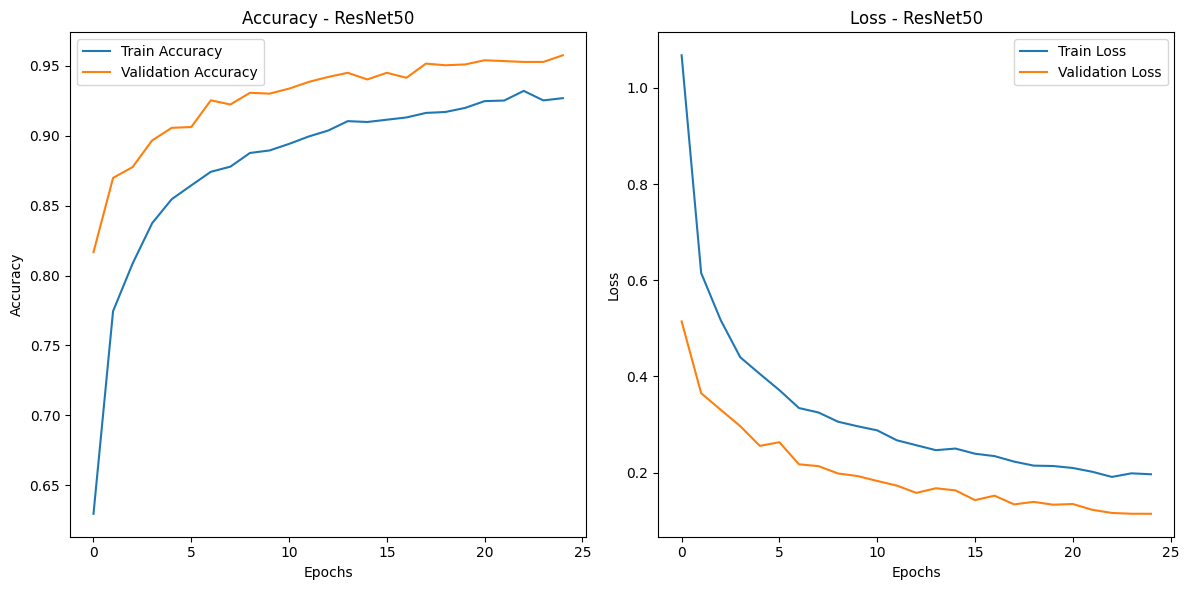

2025/07/05 06:09:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/07/05 06:10:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'ResNet50' already exists. Creating a new version of this model...
Created version '7' of model 'ResNet50'.


Epoch 1/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3441 - loss: 1.9958
Epoch 1: val_loss improved from inf to 0.93181, saving model to models/best_model_VGG16.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 1608s 2s/step - accuracy: 0.3443 - loss: 1.9953 - val_accuracy: 0.6830 - val_loss: 0.9318 - learning_rate: 1.0000e-04
Epoch 2/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6087 - loss: 1.1080
Epoch 2: val_loss improved from 0.93181 to 0.71221, saving model to models/best_model_VGG16.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 1604s 2s/step - accuracy: 0.6087 - loss: 1.1079 - val_accuracy: 0.7570 - val_loss: 0.7122 - learning_rate: 1.0000e-04
Epoch 3/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6814 - loss: 0.9055
Epoch 3: val_loss improved from 0.71221 to 0.61123, saving model to models/best_model_VGG16.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 1604s 2s/step - accuracy: 0.6814 - loss: 0.9055 - val_accuracy: 0.7958 - val_loss: 0.6112 - learning_rate: 1.0000e-04
Epoch 4/25
733

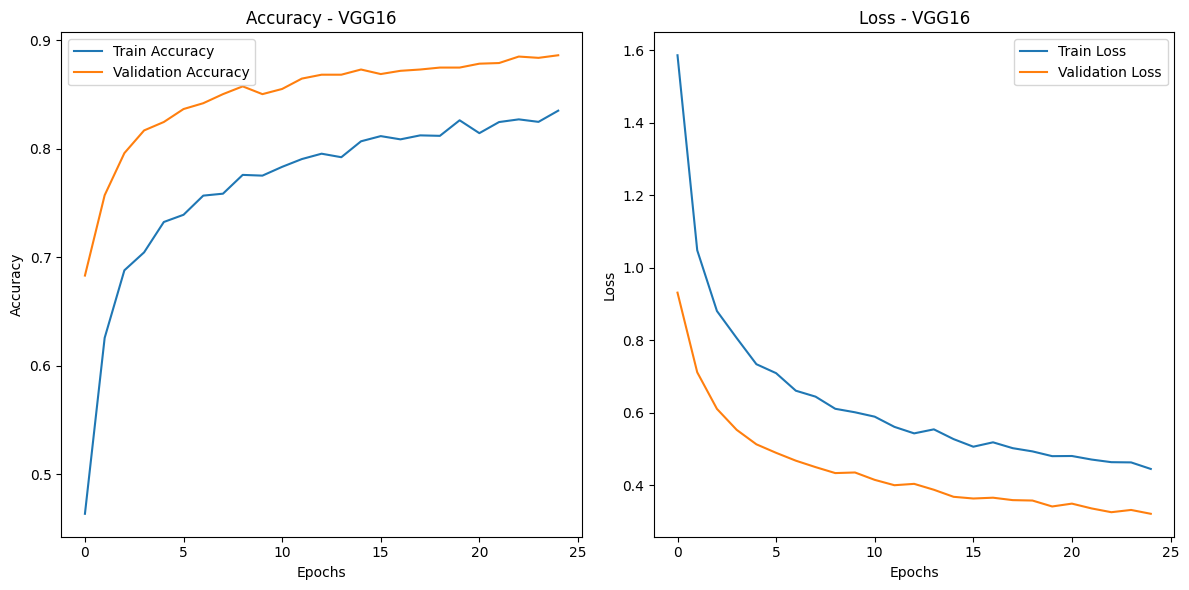

2025/07/05 17:22:12 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/07/05 17:22:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'VGG16' already exists. Creating a new version of this model...
Created version '6' of model 'VGG16'.


Epoch 1/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.4372 - loss: 1.6608
Epoch 1: val_loss improved from inf to 0.74602, saving model to models/best_model_MobileNetV2.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 167s 220ms/step - accuracy: 0.4374 - loss: 1.6603 - val_accuracy: 0.7367 - val_loss: 0.7460 - learning_rate: 1.0000e-04
Epoch 2/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7105 - loss: 0.7955
Epoch 2: val_loss improved from 0.74602 to 0.58331, saving model to models/best_model_MobileNetV2.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 153s 209ms/step - accuracy: 0.7105 - loss: 0.7954 - val_accuracy: 0.8006 - val_loss: 0.5833 - learning_rate: 1.0000e-04
Epoch 3/25
733/733 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7543 - loss: 0.6707
Epoch 3: val_loss improved from 0.58331 to 0.52729, saving model to models/best_model_MobileNetV2.keras
733/733 ━━━━━━━━━━━━━━━━━━━━ 153s 209ms/step - accuracy: 0.7543 - loss: 0.6707 - val_accuracy: 0.8149 - val_loss: 0.5273 - learnin

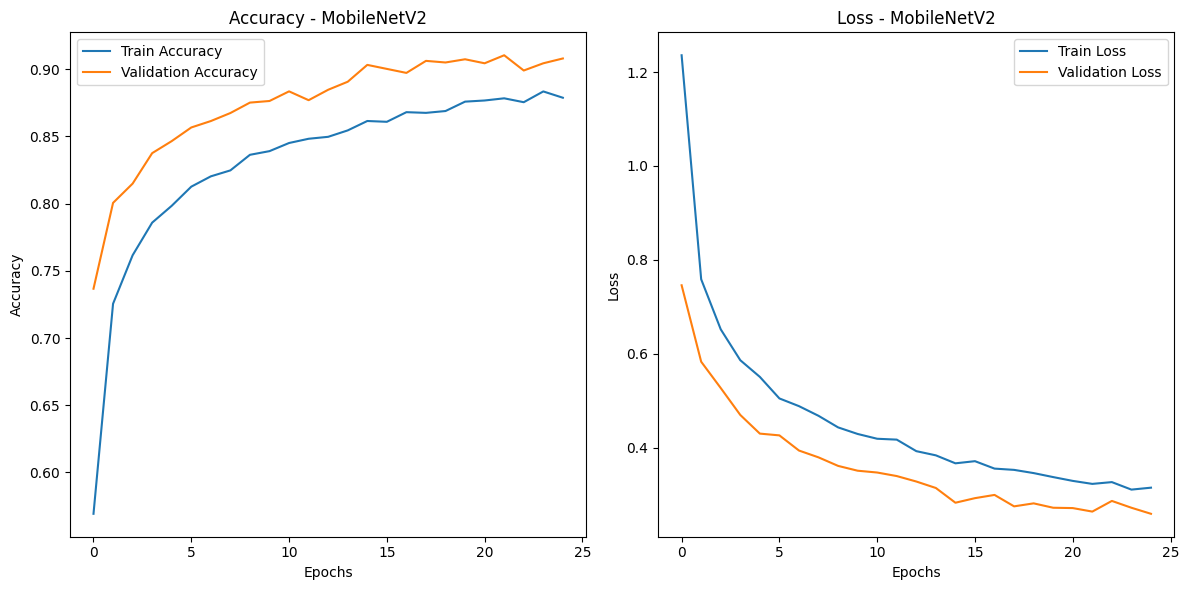

2025/07/05 18:26:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/07/05 18:26:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'MobileNetV2' already exists. Creating a new version of this model...
Created version '6' of model 'MobileNetV2'.


In [ ]:
# === TRAINING EXECUTION ===
training_histories = {}

# Train each model config
for experiment in experiments:
    history = train_and_log_experiment(
        model_name=experiment['model_name'],
        base_model_class=experiment['base_model_class'],
        preprocess_function=experiment['preprocess_function'],
        train_dataset=train_dataset,
        validation_dataset=validation_dataset,
        img_size=IMG_SIZE,
        num_classes=len(class_names),
        class_weight=class_weights
    )
    training_histories[experiment['model_name']] = history 
        

In [ ]:
# === MODEL EVAL FUNCTION ===
def evaluation_model(model_name, preprocess_function, test_dataset):
    """    
    Args:
        1. model_name: Name of the model to evaluate
        2. preprocess_function: Model-specific preprocessing function
        3. test_dataset: Test dataset for evaluation
    """
    
    # Loads the best model saved
    model = tf.keras.models.load_model(f'models/best_model_{model_name}.keras')
    
    # Preprocessing for evaluation
    def preprocess_for_evaluation(image, label):
            return preprocess_function(image), label
    
    # Apply preprocessing to test dataset 
    test_dataset = test_dataset.map(preprocess_for_evaluation, num_parallel_calls=AUTOTUNE)
    
    # Evaluation metrics
    print(f'Evaluation model: {model_name}')
    loss, accuracy = model.evaluate(test_dataset)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    
    print(f'Prediction for every class in test dataset')
    predictions = model.predict(test_dataset)
    predicted_class = np.argmax(predictions, axis=1)
    true_classes = np.concatenate([y for x, y in test_dataset], axis = 0)
    true_classes = np.argmax(true_classes, axis=1)
    
    print(f'Confusion Matrix')
    cm = confusion_matrix(true_classes, predicted_class)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(f"Classifiction Report - {model_name}")
    print(classification_report(true_classes, predicted_class, target_names=class_names))
    
    # y_true_one_hot = tf.keras.utils.to_categorical(true_classes, num_classes=len(class_names))
    # y_pred_probs = predictions
    # num_classes = len(class_names)
    
    y_true = []
    y_pred_probs = []
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        y_pred_probs.extend(model.predict(images))

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    num_classes = len(class_names)
    
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
    # roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # mean_tpr = np.zeros_like(all_fpr)
    # for i in range(num_classes):
    #     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # mean_tpr /= num_classes
    # fpr["macro"] = all_fpr
    # tpr["macro"] = mean_tpr
    # roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # plt.figure(figsize=(12, 10))

    # plt.plot(fpr["micro"], tpr["micro"],
    #          label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
    #          color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
    #          color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    
    

Evaluation model: ResNet50
210/210 ━━━━━━━━━━━━━━━━━━━━ 167s 666ms/step - accuracy: 0.9528 - loss: 0.1318


c:\Users\ricca\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Test Loss: 0.1338
Test Accuracy: 0.9517
Prediction for every class in test dataset
210/210 ━━━━━━━━━━━━━━━━━━━━ 144s 677ms/step
Confusion Matrix


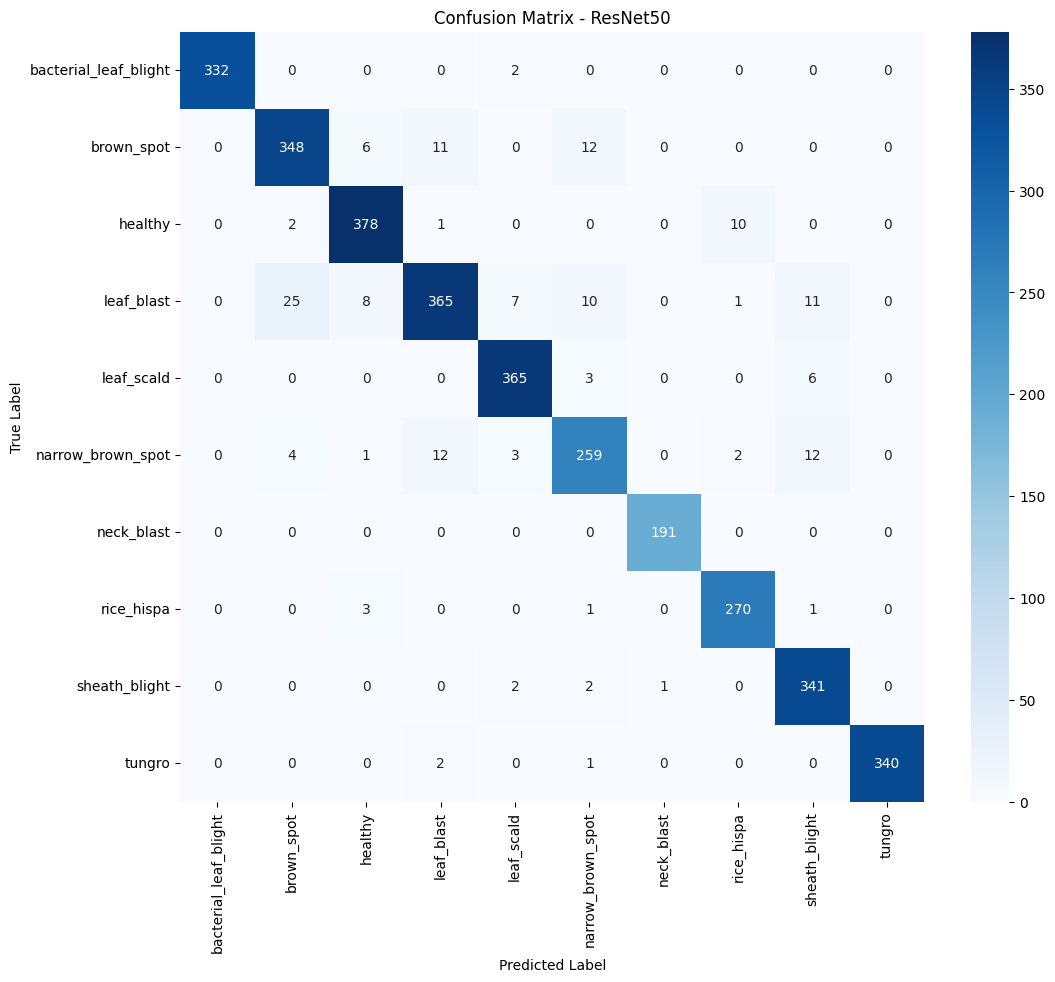

Classifiction Report - ResNet50
                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      0.99      1.00       334
           brown_spot       0.92      0.92      0.92       377
              healthy       0.95      0.97      0.96       391
           leaf_blast       0.93      0.85      0.89       427
           leaf_scald       0.96      0.98      0.97       374
    narrow_brown_spot       0.90      0.88      0.89       293
           neck_blast       0.99      1.00      1.00       191
           rice_hispa       0.95      0.98      0.97       275
        sheath_blight       0.92      0.99      0.95       346
               tungro       1.00      0.99      1.00       343

             accuracy                           0.95      3351
            macro avg       0.95      0.96      0.95      3351
         weighted avg       0.95      0.95      0.95      3351

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━

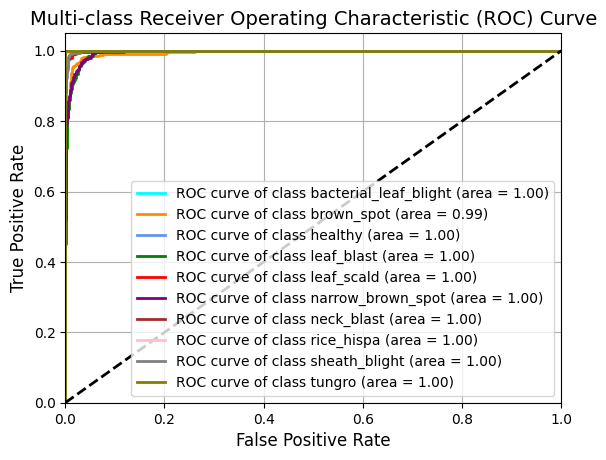

Evaluation model: VGG16
210/210 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.8799 - loss: 0.3554
Test Loss: 0.3609
Test Accuracy: 0.8768
Prediction for every class in test dataset


c:\Users\ricca\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


210/210 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step
Confusion Matrix


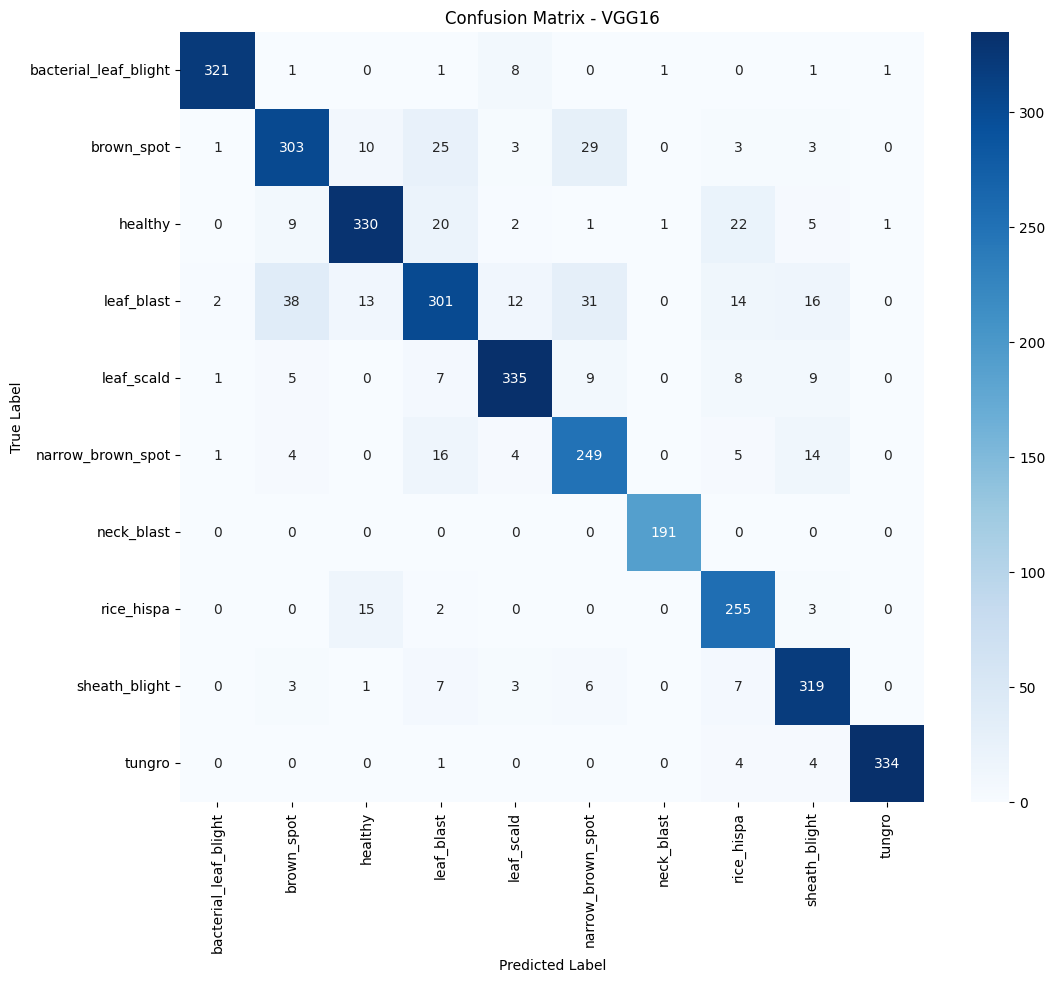

Classifiction Report - VGG16
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.98      0.96      0.97       334
           brown_spot       0.83      0.80      0.82       377
              healthy       0.89      0.84      0.87       391
           leaf_blast       0.79      0.70      0.75       427
           leaf_scald       0.91      0.90      0.90       374
    narrow_brown_spot       0.77      0.85      0.81       293
           neck_blast       0.99      1.00      0.99       191
           rice_hispa       0.80      0.93      0.86       275
        sheath_blight       0.85      0.92      0.89       346
               tungro       0.99      0.97      0.98       343

             accuracy                           0.88      3351
            macro avg       0.88      0.89      0.88      3351
         weighted avg       0.88      0.88      0.88      3351

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━

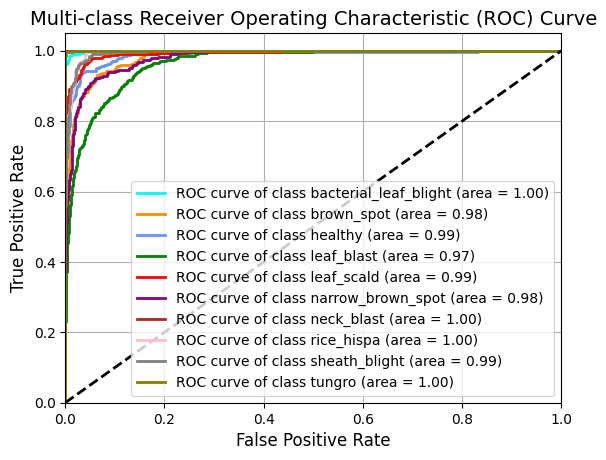

Evaluation model: MobileNetV2
210/210 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - accuracy: 0.8997 - loss: 0.3109
Test Loss: 0.3124
Test Accuracy: 0.8926
Prediction for every class in test dataset


c:\Users\ricca\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


210/210 ━━━━━━━━━━━━━━━━━━━━ 37s 172ms/step
Confusion Matrix


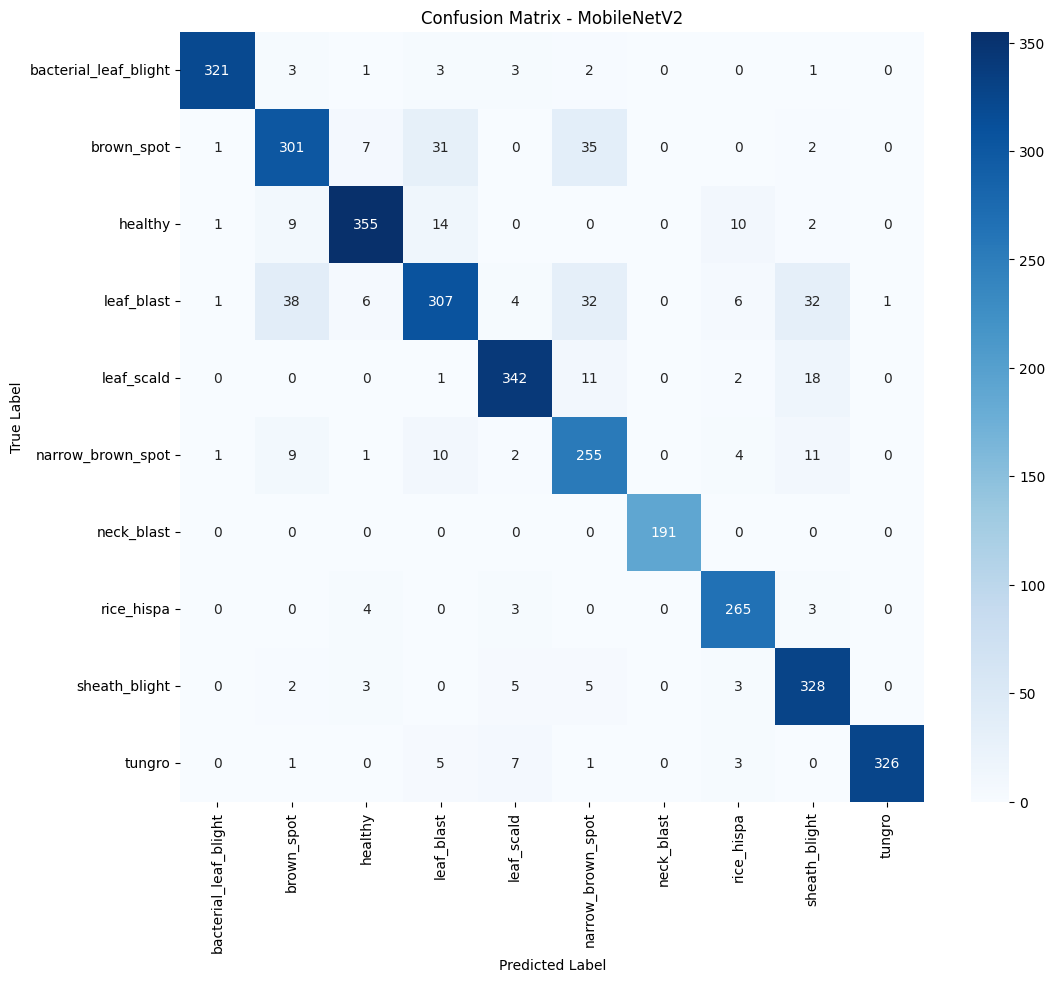

Classifiction Report - MobileNetV2
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.99      0.96      0.97       334
           brown_spot       0.83      0.80      0.81       377
              healthy       0.94      0.91      0.92       391
           leaf_blast       0.83      0.72      0.77       427
           leaf_scald       0.93      0.91      0.92       374
    narrow_brown_spot       0.75      0.87      0.80       293
           neck_blast       1.00      1.00      1.00       191
           rice_hispa       0.90      0.96      0.93       275
        sheath_blight       0.83      0.95      0.88       346
               tungro       1.00      0.95      0.97       343

             accuracy                           0.89      3351
            macro avg       0.90      0.90      0.90      3351
         weighted avg       0.90      0.89      0.89      3351

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━

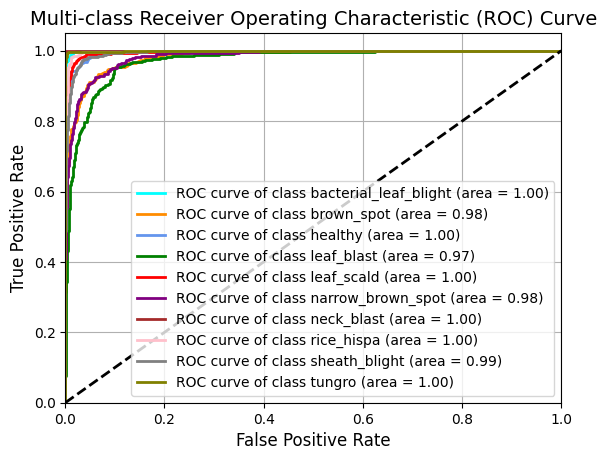

In [16]:
for experiment in experiments:
    evaluation_model(experiment['model_name'], experiment['preprocess_function'], test_dataset)
    

In [ ]:
# === GENERATING GRAD-CAM HEATMAP

def make_gradcam_heatmap(img_array, model, class_index, last_conv_layer_name, pred_index=None):
    
    # Create the model
    grad_model = tf.keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    
    # Record gradients during forward pass
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    # Calculate gradients of class score w.r.t. feature maps
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    
    #  Weight feature maps by their importance and sum them
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Apply ReLU and normalize to [0, 1]
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [ ]:
# Display Grad-CAM image with the original image
def displayGradCAM(img_path, heatmap, true_label, predicted_label, model_name, alpha = 0.4):
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 10))
    
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    ax[0].imshow(img.astype('uint8'))
    ax[0].set_title((f'Original Image - {true_label}'))
    ax[0].axis('off')
    
    heatmap = np.uint8(255 * heatmap)
    
    jet = mpl.colormaps['jet']
    
    jet_colors = jet(np.arange(256))[:, :3] 
    jet_heatmap = jet_colors[heatmap]
    
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img) 
    
    ax[1].imshow(superimposed_img)
    ax[1].set_title(f'Grad-CAM - {predicted_label}')
    ax[1].axis('off')
    
    plt.suptitle(f'Grad-CAM - {model_name}')
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


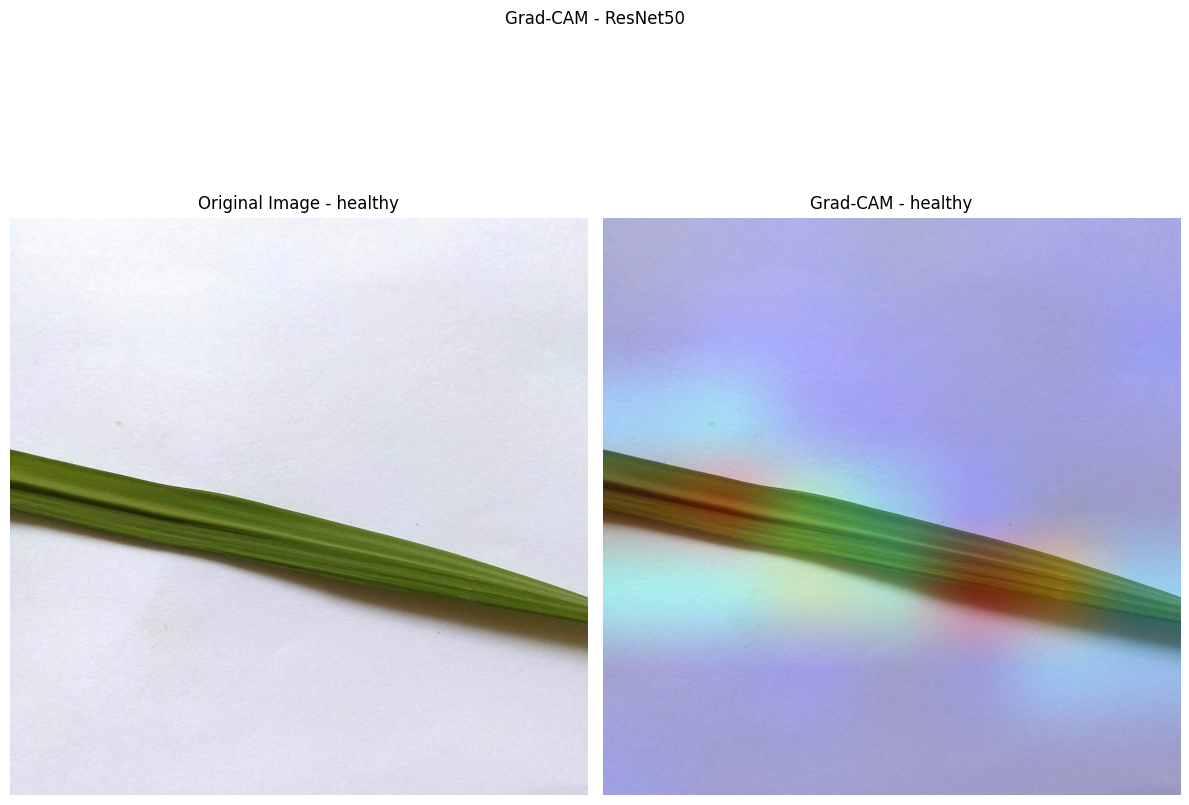

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


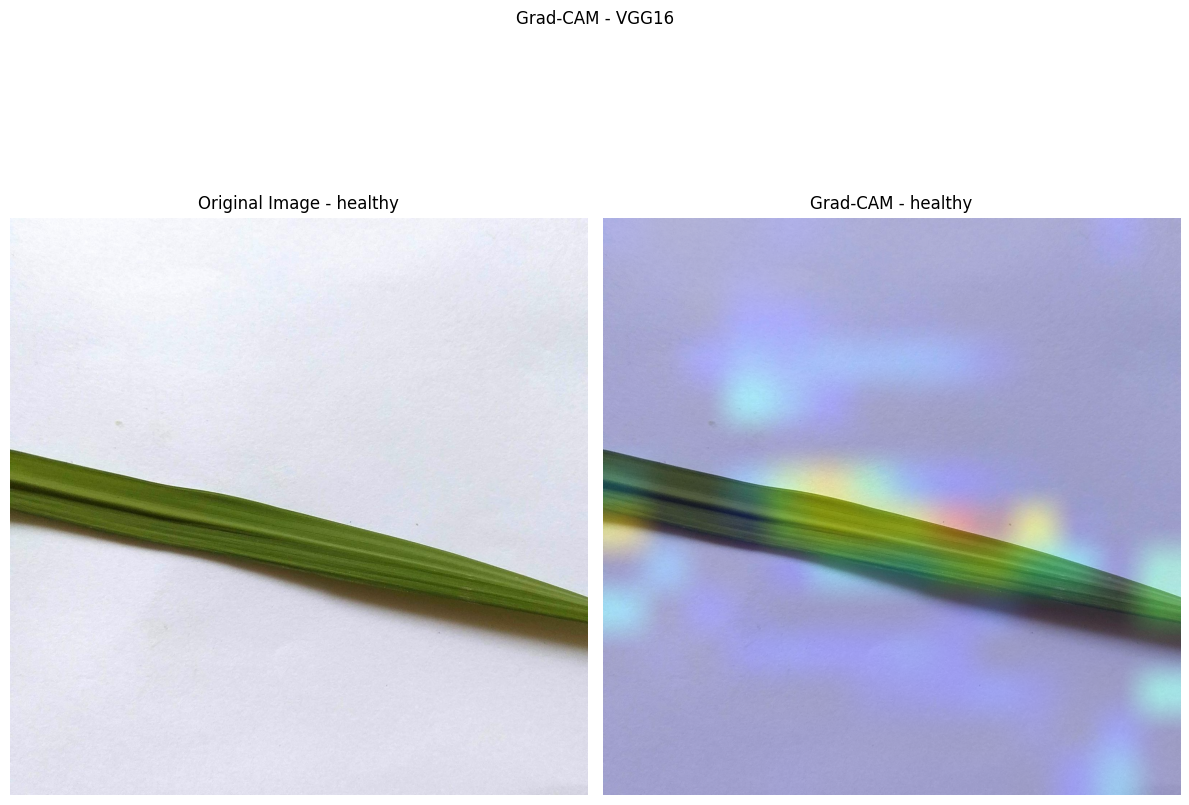

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


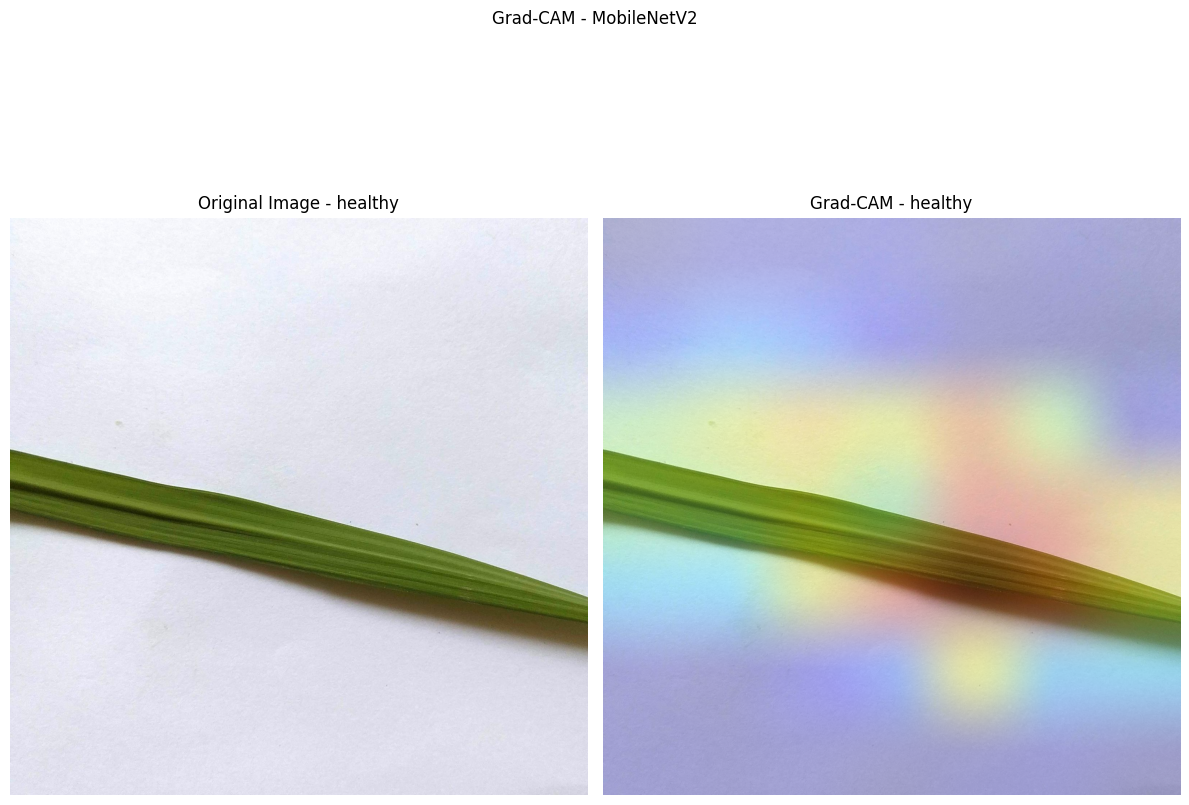

In [ ]:
# image_path = 'Rice_Leaf_Disease/train/leaf_blast/leaf_blast1684.jpg'
# image_path = 'Rice_Leaf_Disease/train/leaf_blast/IMG_20231006_172819.jpg' 
# image_path = 'Rice_Leaf_Disease/train/leaf_blast/mehedi (4).jpg'
# image_path = 'Rice_Leaf_Disease/train/narrow_brown_spot/narrow_brown_spot20.jpg'
# image_path = 'Rice_Leaf_Disease/train/narrow_brown_spot/narrow_brown_spot1396.jpg'
# image_path = 'Rice_Leaf_Disease/train/narrow_brown_spot/narrow_brown_spot7.jpg'
image_path = 'Rice_Leaf_Disease/train/healthy/healthy (5).jpg'
# image_path = 'Rice_Leaf_Disease/train/leaf_scald/IMG_20231014_171232.jpg'
# image_path = 'Rice_Leaf_Disease/train/neck_blast/neck_blast1.jpg'
# image_path = 'Rice_Leaf_Disease/train/sheath_blight/sheath_blight0.jpg'
# image_path = 'Rice_Leaf_Disease/train/sheath_blight/sheath_blight1543.jpg'
# image_path = 'Rice_Leaf_Disease/train/healthy/healthy1053.jpg'
# image_path = 'Rice_Leaf_AUG/Bacterial Leaf Blight/IMG_20231018_143859.jpg'
# image_path = 'healthy2.jpeg'
# image_path = 'Rice_Leaf_AUG/Narrow Brown Leaf Spot/aug_0_63.jpg'
# image_path = 'Rice_Leaf_AUG/Neck_Blast/IMG20201108163557_00.jpg'
# image_path = 'Rice_Leaf_AUG/Rice Hispa/aug_0_120.jpg'

# Process image with the trained models
for experiment in experiments:
    model_name = experiment['model_name']
    base_model = experiment['base_model_class']
    preprocess_function = experiment['preprocess_function']
    
    true_class_name = os.path.basename(os.path.dirname(image_path))
    
    model = tf.keras.models.load_model(f'models/best_model_{model_name}.keras')
    last_conv_layer_name = experiment['last_conv_layer_name']
    
    img_array = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    img_array_processed = preprocess_function(img_array.copy())
    
    preds = model.predict(img_array_processed)
    predicted_class_index = np.argmax(preds[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = preds[0][predicted_class_index]
    
    heatmap = make_gradcam_heatmap(img_array_processed, model, predicted_class_index, last_conv_layer_name)
    displayGradCAM(image_path, heatmap, true_class_name, predicted_class_name, model_name)